In [1]:
from gazpacho import get, Soup

In [2]:
url = 'https://www.goodreads.com/review/list/16626766'

In [3]:
params = {
    'shelf': 'read',
    'order': 'd',
    'sort': 'date_read',
    'per_page': 30, # actually can't change
    'page': 1
}

html = get(url, params)

In [4]:
soup = Soup(html)

In [5]:
trs = soup.find('tr', {'class': 'bookalike review'})
len(trs)

30

In [6]:
tr = trs[0]

In [7]:
tr.find('a', {'href': '/book/show/'})[1].attrs['title']

'The Stupidest Angel: A Heartwarming Tale of Christmas Terror (Pine Cove, #3)'

In [8]:
tr.find('a', {'href': '/author/show'}).text

'Moore, Christopher'

In [9]:
tr.find('span', {'class': 'date_started_value'}).text

'Dec 07, 2019'

In [10]:
tr.find('span', {'class': 'date_read_value'}).text

'Dec 11, 2019'

In [11]:
tr.find('nobr').remove_tags()

'300 pp'

In [12]:
def parse_tr(tr):
    return {
        'title': tr.find('a', {'href': '/book/show/'})[1].attrs['title'],
        'author': tr.find('a', {'href': '/author/show'}).text,
        'end': tr.find('span', {'class': 'date_read_value'}).text,
    }

In [13]:
books = [parse_tr(tr) for tr in trs]

In [14]:
books[:3]

[{'title': 'The Stupidest Angel: A Heartwarming Tale of Christmas Terror (Pine Cove, #3)',
  'author': 'Moore, Christopher',
  'end': 'Dec 11, 2019'},
 {'title': 'The Madness of Crowds: Gender, Race and Identity',
  'author': 'Murray, Douglas',
  'end': 'Dec 07, 2019'},
 {'title': 'The Reluctant Fundamentalist',
  'author': 'Hamid, Mohsin',
  'end': 'Dec 03, 2019'}]

In [15]:
def scrape_page(user=16626766, page=1):
    url = f'https://www.goodreads.com/review/list/{user}'
    params = {
        'shelf': 'read',
        'order': 'd',
        'sort': 'date_read',
        'page': page
    }
    html = get(url, params)
    soup = Soup(html)
    trs = soup.find('tr', {'class': 'bookalike review'})
    books = [parse_tr(tr) for tr in trs]
    return books

In [16]:
books = []
for page in [1, 2]:
    books.extend(scrape_page(page=page))

In [17]:
from tqdm import tqdm
import time

In [18]:
books = []
pages = 5 * 52 // 30 + 1
for page in tqdm(range(1, pages+1)):
    books.extend(scrape_page(page=page))
    time.sleep(1)

100%|██████████| 9/9 [00:36<00:00,  3.95s/it]


In [19]:
import pandas as pd

In [20]:
df = pd.DataFrame(books)

df.to_csv('data/books.csv', index=False)

In [21]:
df['end'] = pd.to_datetime(df['end'])
df = df.sort_values('end', ascending=True)
df['year'] = df['end'].dt.year
df['week'] = df['end'].dt.dayofyear // 7 + 1
df['read'] = 1

stats = df.groupby(['year', 'week'])['read'].count().groupby(['year']).cumsum()
df = stats.reset_index()

In [22]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

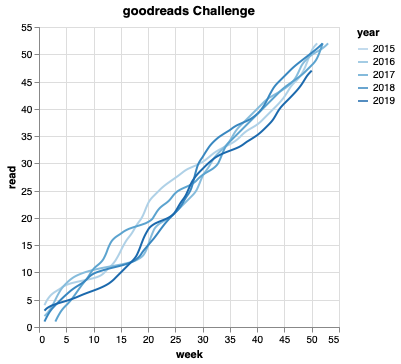

In [23]:
chart = (
    alt.Chart(df)
    .mark_line(interpolate='basis')
    .encode(
        x='week',
        y='read',
        color='year:O')
    .properties(
        height=300, 
        width=300,
        title='goodreads Challenge'
    )
)

chart

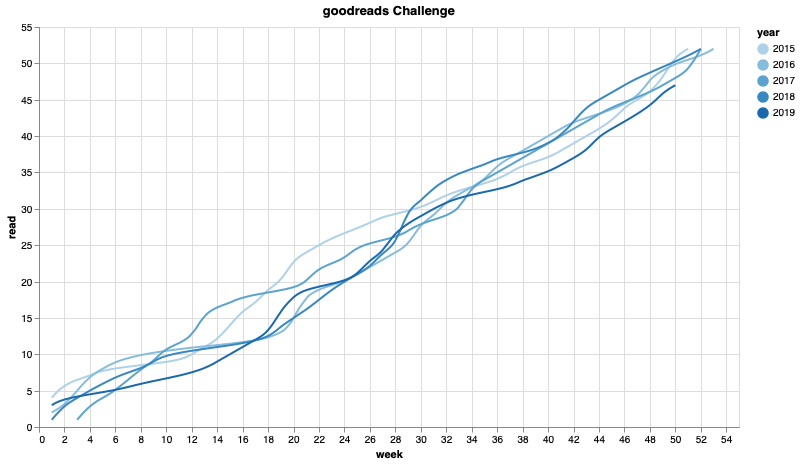

In [24]:
from utils import interactive_chart

interactive_chart(df)